## Interaction dataset

We have several ways to go from raw data to the dataset, we can work with.

1. Starting from a pkl file that was created for the fully convolutional scene graph generation model. In this file, we have one dictionary entry per image frame, which could contain several interactions. We want to create a new dictionary from this, which contains one entry per interaction (and also includes some negative samples without interaction).
2. Starting from interaction labels (either BORIS or our app) and tracking labels, create a dictionary which contains one entry per frame.
3. Starting from interaction labels (either BORIS or our app) and tracking labels, create a dictionary which contains one entry per interaction (including negative samples without interaction).

### 1. Pickle file to interaction dictionary

In [8]:
import os
import pickle
import random


In [9]:
# Specify the path to the .pkl file
pkl_file_path = '../../fcsgg/lemurs/data/data/pkls/lemur_test.pkl' #'../../fcsgg/lemurs/data/data/pkls/lemur_train.pkl'


class IgnoreUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if "detectron2" in module:  # Check if "detectron2" is a substring of module
            print(f"Warning: Skipping loading module {module}. Returning a placeholder.")
            return lambda *args, **kwargs: None  # Return a placeholder (e.g., a lambda function)
        return super().find_class(module, name)

# Load the pickle file with the custom Unpickler
with open(pkl_file_path, 'rb') as file:
    unpickler = IgnoreUnpickler(file)
    data = unpickler.load()

In [10]:
len(data)

52230

In [12]:
i = 1500
new_dict_list = []

#file_name lemurs/data/data/frames/train/9/c6/frame15047.jpg

# Function to extract the frame number from the file name
def extract_frame_number(file_name):
    # Extract the frame number by splitting on "frame" and ".jpg"
    return int(file_name.split("/")[-1].split('frame')[1].split('.jpg')[0])

frames_with_indices = [(idx, extract_frame_number(d['file_name'])) for idx, d in enumerate(data)]

# Identify consecutive sequences
sequences = []
current_sequence = [frames_with_indices[0]]  # Start with the first frame

for i in range(1, len(frames_with_indices)):
    # Check if the current frame continues the sequence
    if frames_with_indices[i][1] == frames_with_indices[i - 1][1] + 1:
        current_sequence.append(frames_with_indices[i])
    else:
        # A break in the sequence occurred, store the current sequence and start a new one
        sequences.append(current_sequence)
        current_sequence = [frames_with_indices[i]]

# Don't forget to add the last sequence
if current_sequence:
    sequences.append(current_sequence)

# Remove the first 10 and last 10 frame indices from each sequence
filtered_indices = []
for sequence in sequences:
    if len(sequence) > 20:  # Only filter if sequence is longer than 20 frames
        filtered_indices.extend([idx for idx, _ in sequence[10:-10]])
    else:
        filtered_indices.extend([idx for idx, _ in sequence])

# Sample 10,000 indices from the filtered indices
sampled_indices = random.sample(filtered_indices, min(1000, len(filtered_indices)))

# The sampled indices correspond to the indices in data_list. You can use them to get the corresponding frames:
sampled_frames = [data[idx] for idx in sampled_indices]
new_dict_list = []

for labels in sampled_frames:
    relations = labels['relations']
    detections = labels['annotations']
    image_path = labels['file_name']

    if len(relations) == 0:
        continue
    else:
        for relation in relations:
            # Add positive example
            new_dict = {
                'file_name': image_path,
                'bbox': [detections[relation[1]]['bbox'], detections[relation[0]]['bbox']],
                'label': relation[2] + 1
            }
            new_dict_list.append(new_dict)
            
            # Add negative example
            bbox_index = [index for index, detection in enumerate(detections) if detection['category_id'] == 0]
            bbox_index = random.sample(bbox_index, 1)[0]

            other_bbox_index = random.randint(0, len(detections) - 1)
            while other_bbox_index == bbox_index:
                other_bbox_index = random.randint(0, len(detections) - 1)

            # Make sure that the negative example is not a positive example    
            while [other_bbox_index, bbox_index, 0] in relations:
                bbox_index = [index for index, detection in enumerate(detections) if detection['category_id'] == 0]
                bbox_index = random.sample(bbox_index, 1)[0]

                other_bbox_index = random.randint(0, len(detections) - 1)
                while other_bbox_index == bbox_index:
                    other_bbox_index = random.randint(0, len(detections) - 1)

            new_dict = {
                'file_name': image_path,
                'bbox': [detections[bbox_index]['bbox'], detections[other_bbox_index]['bbox']],
                'label': 0
            }
            new_dict_list.append(new_dict)

for item in new_dict_list:
    print(item)

# Save the new_dict_list to a pickle file
with open('../../fcsgg/lemurs/data/data/pkls/new_lemur_test.pkl', 'wb') as file:
    pickle.dump(new_dict_list, file)

{'file_name': 'lemurs/data/data/frames/val/7/c6/frame7423.jpg', 'bbox': [[1076.7283718267793, 663.8992113173875, 173.813045135997, 146.44607260537174], [1190.22661601012, 681.7701940188326, 123.97611674424456, 82.63223957841058]], 'label': 1}
{'file_name': 'lemurs/data/data/frames/val/7/c6/frame7423.jpg', 'bbox': [[1134.2822804405555, 793.8173324012268, 112.0876630653227, 152.80497926695568], [1190.22661601012, 681.7701940188326, 123.97611674424456, 82.63223957841058]], 'label': 0}
{'file_name': 'lemurs/data/data/frames/val/7/c6/frame7423.jpg', 'bbox': [[1076.7283718267793, 663.8992113173875, 173.813045135997, 146.44607260537174], [1134.2822804405555, 793.8173324012268, 112.0876630653227, 152.80497926695568]], 'label': 1}
{'file_name': 'lemurs/data/data/frames/val/7/c6/frame7423.jpg', 'bbox': [[1076.7283718267793, 663.8992113173875, 173.813045135997, 146.44607260537174], [1198.287582945086, 729.7629119645094, 201.8761284179697, 195.04041865067683]], 'label': 0}
{'file_name': 'lemurs/da

In [5]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import random


import sys
sys.path.append('../src/lib/')

import datasets.dataset as dataset

In [6]:
dset_interactions = dataset.InteractionTripletDataset(
    root = "../../fcsgg/",
    file_name = "lemurs/data/data/pkls/new_lemur_train.pkl"
    )

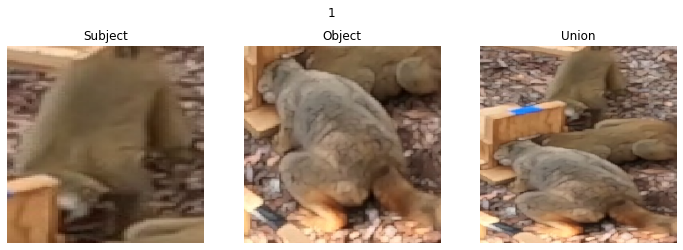

In [7]:
import matplotlib.pyplot as plt

### for some reason I only get constant pixel values, no lemur images. Need to check the dataset class

first_element = dset_interactions[698]

# Assuming your tensors are stored in a dictionary under the keys 'subj', 'obj', and 'union'
tensor_subj = first_element['subj']
tensor_obj = first_element['obj']
tensor_union = first_element['union']

# If the tensors are in the shape (1, C, H, W), remove the batch dimension
if tensor_subj.dim() == 4:
    tensor_subj = tensor_subj.squeeze(0)  # Remove batch dimension, shape (C, H, W)
if tensor_obj.dim() == 4:
    tensor_obj = tensor_obj.squeeze(0)  # Remove batch dimension, shape (C, H, W)
if tensor_union.dim() == 4:
    tensor_union = tensor_union.squeeze(0)  # Remove batch dimension, shape (C, H, W)

# If the tensors are in the shape (C, H, W), permute them to (H, W, C)
if tensor_subj.shape[0] == 3:  # For RGB images
    tensor_subj = tensor_subj.permute(1, 2, 0)
if tensor_obj.shape[0] == 3:  # For RGB images
    tensor_obj = tensor_obj.permute(1, 2, 0)
if tensor_union.shape[0] == 3:  # For RGB images
    tensor_union = tensor_union.permute(1, 2, 0)

# Convert the tensors to NumPy arrays
numpy_subj = tensor_subj.detach().cpu().numpy()
numpy_obj = tensor_obj.detach().cpu().numpy()
numpy_union = tensor_union.detach().cpu().numpy()

# Plot the images using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(numpy_subj.astype('uint8'))  # Convert to 'uint8' if needed
axes[0].axis('off')  # Hide the axes
axes[0].set_title('Subject')

axes[1].imshow(numpy_obj.astype('uint8'))  # Convert to 'uint8' if needed
axes[1].axis('off')  # Hide the axes
axes[1].set_title('Object')

axes[2].imshow(numpy_union.astype('uint8'))  # Convert to 'uint8' if needed
axes[2].axis('off')  # Hide the axes
axes[2].set_title('Union')

title = first_element['label']
plt.suptitle(title)

plt.show()